A notebook to test reading in ROSETTA radar matfiles and calculating ice thickness

For use with NASA COMBINED (hydrostatic appx and ice densities)

In [104]:
import os
import sys
import numpy as np
# import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
# import cmocean
import xarray as xr
import seaborn as sns
from scipy.io import loadmat

# from osgeo import ogr
import geopandas as gpd
# import shapefile as shp

import rasterio
def print_raster(raster):
    print(
        f"shape: {raster.shape}\n"
#         f"resolution: {raster.resolution()}\n"
        f"bounds: {raster.bounds}\n"
#         f"sum: {raster.sum().item()}\n"
        f"CRS: {raster.crs}\n"
    )

# Read in matfile from local data directory

## constants

In [30]:
cAir = 299792458;   # m/s
cIce = 1.68e8;      # m/s


## Point to File

In [3]:
# Determine where to look #
basedir = '/Users/dporter/data/'
# basedir = 'data'
# basedir = '/Users/dporter/Documents/Research/Projects/bedclass/data'

datadir = 'Antarctic/ROSETTA/radar/'

In [8]:
suffix = '.mat'
datafile = 'AN02_F1005_1usCh1_20151116_094349_23_Picks'

matfile = os.path.join(basedir, datadir, datafile + suffix)
print(matfile)

/Users/dporter/data/Antarctic/ROSETTA/radar/AN02_F1005_1usCh1_20151116_094349_23_Picks.mat


## Loadmat

In [9]:
matdata = loadmat(matfile)
print(matdata.keys())

dict_keys(['__header__', '__version__', '__globals__', 'pickername', 'NOTE_VertScale', 'Time', 'Surf_Elev', 'GPS_time', 'FlightElev', 'SurfTime', 'Lat', 'Lon', 'Pixel', 'PickTime', 'X', 'Y', 'Distance', 'xdisp', 'Depth', 'Bright', 'MultipleBright', 'NoiseFloor', 'Notes', 'Data', 'VertScale'])


In [71]:
matdata['Data'].shape

(2863, 1832)

## grab cells we need, naming like in Tej's .m file

In [118]:
Data = matdata['Data'][:].squeeze()
PickTime = matdata['PickTime'][:].squeeze()
X = matdata['X'][:].squeeze()
Y = matdata['Y'][:].squeeze()
lat = matdata['Lat'][:].squeeze()
lon = matdata['Lon'][:].squeeze()

Elev = matdata['FlightElev'][:].squeeze()
Surf = matdata['SurfTime'][:].squeeze()  # SurfTime, or Surf_Elev
Surf_elev = matdata['Surf_Elev'][:].squeeze()
Flightelev = matdata['FlightElev'][:].squeeze()  
Time = matdata['Time'][:].squeeze()
Depth = matdata['Depth'][:].squeeze()

In [119]:
print(PickTime.shape)
print(X.shape)
print(Time.shape)
print(Data.shape)

print(Time[:5])

(1832,)
(1832,)
(2863,)
(2863, 1832)
[-2.11369459e-06 -2.10702678e-06 -2.10035897e-06 -2.09369117e-06
 -2.08702336e-06]


### Derive new variables

`PickTime`

In [116]:
PickDepth = -(.5*cIce)*PickTime
 

### Plot `derived` thickness to make sure I'm interpretting variables correction

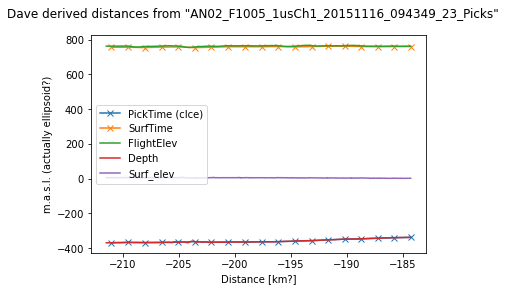

In [122]:
plt.plot(X[::100], PickDepth[::100], marker='x', label='PickTime (cIce)')
plt.plot(X[::100], (.5*cAir)*Surf[::100], marker='x', label='SurfTime')
plt.plot(X, Flightelev, label='FlightElev')
plt.plot(X, Depth, label='Depth')
plt.plot(X, Surf_elev, label='Surf_elev')
plt.suptitle(f'Dave derived distances from "{datafile}"')
plt.xlabel('Distance [km?]')
plt.ylabel('m.a.s.l. (actually ellipsoid?)')
plt.legend()
plt.savefig(f'figs/test_read_ROSETTA_radar-matfiles_DICE.png')

### Test Tej's calcs done in matlab

In [ ]:
aboveSurf = Elev - (.5*cAir)*(Surf)
# np.matlib.repmat(Time,[(np.shape(Surf),1),1]) - Surf
newTime = np.tile(Time,(1,Data.size))

print(Surf.size)
print(aboveSurf.shape)
print(Time.shape)
print(newTime.shape)
print(newTime[:5])

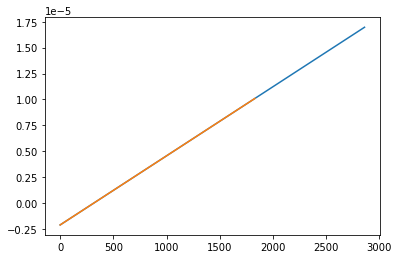

In [68]:
plt.plot(Time)
plt.plot(Time[:aboveSurf.shape[0]])

### weird `belowSurf` calculation?

In [69]:
# belowSurf = (newTime - Surf)*(cIce*0.5)
belowSurf = Time[:aboveSurf.shape[0]]*(cIce*0.5)
Elevcorr = (aboveSurf - belowSurf)*1
# Time

## Convert `data` (twtt?) with 20log10()

In [73]:
## TWTT?
data32 = np.float32(20*np.log10(np.abs(Data)))

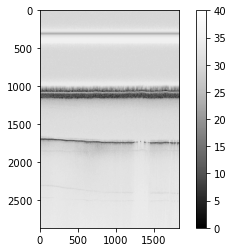

In [97]:
plt.imshow(data32,
           vmin = 0, vmax = 40,
           cmap='Greys_r',
           )
plt.colorbar()

# construct a pandas `dataframe`

In [99]:
df = pd.DataFrame(data=[PickTime, Surf_elev, X, Y, lat, lon]).T

df.rename(columns={0: 'PickTime', 1: 'Surf_elev', 2: 'EPSG_X', 3: 'EPSG_Y', 4: 'lat', 5: 'lon'}, inplace=True)
df

,PickTime,Surf_elev,EPSG_X,EPSG_Y,lat,lon
0,0.000004,1.642791,-184.272409,-1160.289092,-79.218246,-170.975883
1,0.000004,1.641791,-184.286976,-1160.289100,-79.218225,-170.975182
2,0.000004,1.642791,-184.301545,-1160.289108,-79.218204,-170.974480
3,0.000004,1.649791,-184.316114,-1160.289120,-79.218184,-170.973778
4,0.000004,1.656791,-184.330685,-1160.289137,-79.218163,-170.973077
...,...,...,...,...,...,...
1827,0.000004,4.996407,-211.432332,-1160.279087,-79.176679,-169.672569
1828,0.000004,5.020175,-211.447297,-1160.279011,-79.176655,-169.671853
1829,0.000004,5.052943,-211.462262,-1160.278946,-79.176631,-169.671138
1830,0.000004,5.096063,-211.477228,-1160.278889,-79.176608,-169.670422


In [79]:
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1832 entries, 0 to 1831
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PickTime   1832 non-null   float64
 1   Surf_elev  1832 non-null   float64
 2   EPSG_X     1832 non-null   float64
 3   EPSG_Y     1832 non-null   float64
dtypes: float64(4)
memory usage: 57.4 KB
None


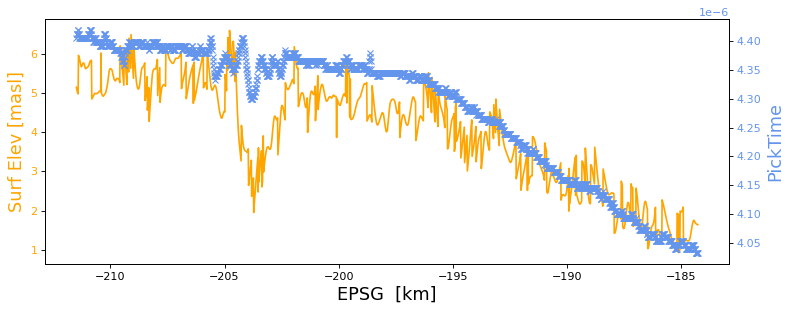

In [113]:
fig, ax = plt.subplots(figsize=(10, 4), dpi=80)

ax.plot(df.EPSG_X, df.Surf_elev, color='orange')
# ax.plot(df.EPSG_X, Depth, color='black')
ax.tick_params(axis='y', labelcolor='orange')
ax.set_ylabel('Surf Elev [masl]', color='orange', fontsize=16)
ax.set_xlabel('EPSG  [km]', color='black', fontsize=16)
# add_basin_locs()

ax2 = ax.twinx()
ax2.plot(df.EPSG_X, df.PickTime, color='cornflowerblue', ls='', marker='x')
ax2.tick_params(axis='y', labelcolor='cornflowerblue')
ax2.set_ylabel('PickTime', color='cornflowerblue', fontsize=16)

# ax4 = ax.twinx()
# ax4.plot(df['Dist'].loc[df['water'] >= 0.1]/1e3, df['water'].loc[df['water'] >= 0.1], color='green', ls='', marker='*')
# ax4.tick_params(axis='y', labelcolor='green')
# ax4.set_ylabel('Water', color='green', fontsize=16)
# ax4.spines['right'].set_position(('axes', 1.2))


plt.tight_layout()
# plt.savefig('figs/lineplot_UTG_sample_ClassBeta.png')

## Convert to GeoPandas `dataframe`

In [106]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.lon, df.lat)
)

## Read in Antarctica catchments shapefile for plotting

In [80]:
## fix PROJ path
import pyproj

projpath = sys.prefix + '/share/proj'
pyproj.datadir.set_data_dir(projpath)

/Users/dporter/opt/anaconda3/envs/bedclass/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [81]:
# data/ASE_catchments_matchGL.geojson
# data/ASE_GroundingLine_simple.geojson

outlines = 'data/ASE_catchments+GL_3031.shp'

shapefile = gpd.read_file(outlines)

shapefile.head()

,groundedic,grounded_1,geometry
0,Grounded,GR,"POLYGON ((-1608074.997 -638549.999, -1608123.7..."
1,Grounded,GR,"POLYGON ((-1739481.254 -401608.850, -1740262.4..."
2,Grounded,GR,"POLYGON ((-1609325.000 -722675.000, -1609325.0..."
3,Grounded,GR,"MULTIPOLYGON (((-1604824.996 -612051.692, -160..."
4,Grounded,GR,"POLYGON ((-1908272.291 -410339.703, -1908540.1..."


In [82]:
from matplotlib.colors import ListedColormap

cmap = np.zeros([256, 4])
cmap[:, 3] = np.linspace(0, 1, 256)
cmap = ListedColormap(cmap)

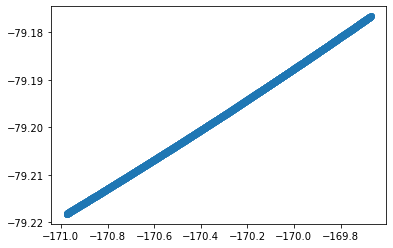

In [102]:
# plt.scatter(df.EPSG_X, df.EPSG_Y)
plt.scatter(df.lon, df.lat)

(-1500000.0, -400000.0)

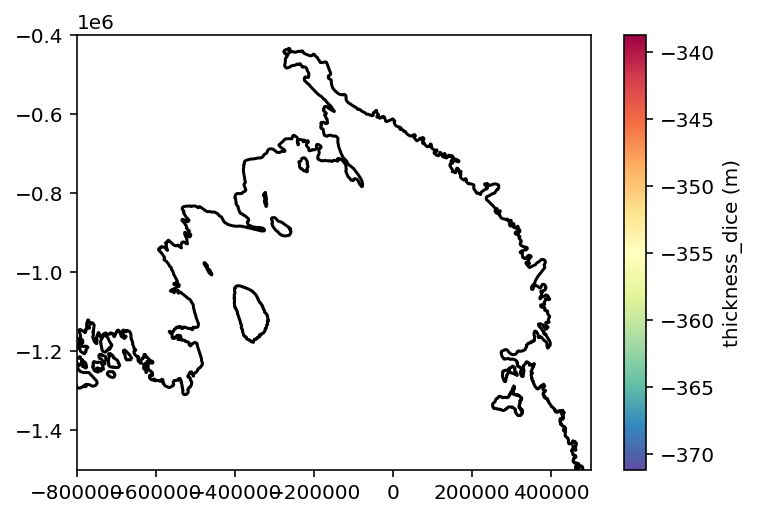

In [100]:
fig, ax = plt.subplots(dpi=144)  # figsize=(8, 8), 
ax.set_aspect('equal')

shapefile.boundary.plot(ax=ax, edgecolor='black')

plt.scatter(df.lon, df.lat, c=-(.5*cIce)*PickTime,
            # vmin=60, vmax=600,
            marker='.',
            cmap="Spectral_r",
           )
plt.colorbar(label="thickness_dice (m)")

# plt.scatter(df_ASE.X, df_ASE.Y, c=y_pred_ASE, 
#             marker='.',
#             cmap=cmap, edgecolors=None)
# plt.scatter(line.X_EPSG_3031[::500], line.Y_EPSG_3031[::500], 
#             c='black',
#             marker='.',
#             cmap=cmap, edgecolors=None,
#             )

plt.xlim(-0.8e6, 0.5e6)
plt.ylim(-1.5e6, -0.4e6)

# plt.savefig('figs/mapplot_ASE_ypred_antgg.png')
